In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings
from torch.utils.data import DataLoader
from tqdm import tqdm

from data import load
from dataset import SARTDataset
from models.transformer_models import DecisionTransformer, configure_optimizers

In [2]:
plt.style.use("bmh")
warnings.filterwarnings(action="ignore")

In [3]:
data_path = "../data/mdp/S1000_A10_R5_T2_R1/"
factory, metadata, data = load(data_path)

In [4]:
print(metadata)

{'n_states': 1000, 'n_actions': 10, 'n_rewards': 5, 'target_return': 1.0, 'data_min_step': 2, 'data_max_step': 408, 'terminate_state_p': 1e-06, 'random_play_p': 0.5, 'n_replay': 10000}


In [5]:
n_states = metadata["n_states"]
n_actions = metadata["n_actions"]
target_return = metadata["target_return"]
max_t = metadata["data_max_step"]

In [6]:
max_length = 12
dataset = SARTDataset(data, max_length=max_length, n_states=n_states, n_actions=n_actions)
len(dataset)

331537

In [7]:
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [8]:
model = DecisionTransformer(n_states, n_actions, max_length=max_length, max_t=max_t, 
                            n_heads=8, n_blocks=6, embedding_dim=128)
optimizer = configure_optimizers(model, lr=6e-4, weight_decay=0, betas=(0.9, 0.95))

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(model, dataloader, optimizer, num_epochs=10):
    model.to(device)
    model.train()

    all_loss = []
    loss_fn = nn.CrossEntropyLoss()

    progress_bar = tqdm(range(num_epochs), "Training")
    for epoch in progress_bar:
        total_loss = 0.0

        for states, actions, rtgs, timesteps, targets in dataloader:
            states, actions, rtgs, timesteps, targets = (
                states.to(device),
                actions.to(device),
                rtgs.to(device),
                timesteps.to(device),
                targets.to(device),
            )
            optimizer.zero_grad()
            predictions = model(states, actions, rtgs, timesteps)
            loss = loss_fn(predictions.view(-1, n_actions), targets.reshape(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        average_loss = total_loss / len(dataloader)
        progress_bar.set_description(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}")
        all_loss.append(average_loss)

    return all_loss

In [10]:
all_loss = train(model, dataloader, optimizer, num_epochs=10)

Epoch 10/10, Loss: 1.0609: 100%|██████████| 10/10 [1:22:09<00:00, 492.93s/it]


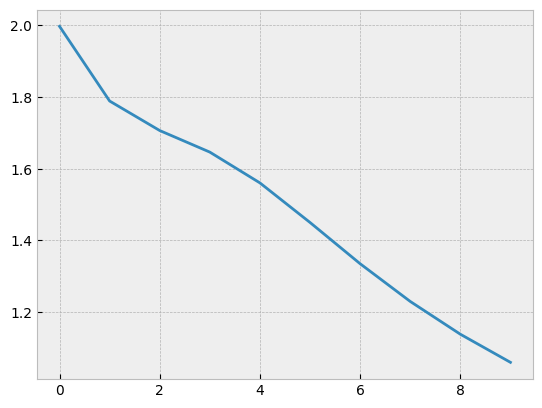

In [11]:
plt.plot(all_loss)
plt.show()

In [12]:
factory.train_policy()

In [27]:
seed = 42
target_return = metadata["target_return"]
state, info = factory.model.reset(seed=seed)
state = factory.model._current_state
action = factory.get_policy()[state]
next_state, reward, terminated, truncated, info = factory.model.step(action)

states, actions, rtgs, rewards, times = [], [], [], [], []
print("Action", "=>", "State", "Reward", "Done", "Trunc.", "Info", "Score", sep="\t") 
print(".\t =>", state, None, False, False, info, sep="\t")
print(action, "=>", next_state, reward, terminated, truncated, info, sep="\t")
state = next_state

for t in range(10_000):
    states.append(int(state))
    actions.append(int(action))
    rewards.append(float(reward))
    times.append(int(t))
    if t == 0:
        rtgs.append(target_return - reward)
    else:
        rtgs.append(rtgs[-1] - reward)

    if len(states) >= max_length // 3:
        states = states[-max_length // 3:]
        actions = actions[-max_length // 3:]
        rtgs = rtgs[-max_length // 3:]
        times = times[-max_length // 3:]

    states_, actions_, rtgs_, times_ = (
        torch.LongTensor(states).reshape(1, -1), 
        torch.LongTensor(actions).reshape(1, -1),
        torch.FloatTensor(rtgs).reshape(1, -1),
        torch.LongTensor(times).reshape(1, -1)
    )
    print(states, actions, rtgs, times)
    action =  model(states_, actions_, rtgs_, times_).argmax(dim=-1)[0, -1].item()
    next_state, reward, terminated, truncated, info = factory.model.step(action)

    state = next_state

    print(action, "=>", next_state, reward, terminated, truncated, info, sum(rewards), sep="\t")
    if terminated or truncated:
        break

score = sum(rewards)
print("Score :", score)

Action	=>	State	Reward	Done	Trunc.	Info	Score
.	 =>	0	None	False	False	{}
6	=>	900	0	False	False	{}
[900] [6] [1.0] [0]
2	=>	75	0	False	False	{}	0.0
[900, 75] [6, 2] [1.0, 1.0] [0, 1]
8	=>	149	0	False	False	{}	0.0
[900, 75, 149] [6, 2, 8] [1.0, 1.0, 1.0] [0, 1, 2]
9	=>	109	0	False	False	{}	0.0
[900, 75, 149, 109] [6, 2, 8, 9] [1.0, 1.0, 1.0, 1.0] [0, 1, 2, 3]
9	=>	605	0	False	False	{}	0.0
[75, 149, 109, 605] [2, 8, 9, 9] [1.0, 1.0, 1.0, 1.0] [1, 2, 3, 4]
1	=>	513	-3	False	False	{}	0.0
[149, 109, 605, 513] [8, 9, 9, 1] [1.0, 1.0, 1.0, 4.0] [2, 3, 4, 5]
0	=>	757	-3	False	False	{}	-3.0
[109, 605, 513, 757] [9, 9, 1, 0] [1.0, 1.0, 4.0, 7.0] [3, 4, 5, 6]
7	=>	795	0	False	False	{}	-6.0
[605, 513, 757, 795] [9, 1, 0, 7] [1.0, 4.0, 7.0, 7.0] [4, 5, 6, 7]
5	=>	604	0	False	False	{}	-6.0
[513, 757, 795, 604] [1, 0, 7, 5] [4.0, 7.0, 7.0, 7.0] [5, 6, 7, 8]
0	=>	644	-2	False	False	{}	-6.0
[757, 795, 604, 644] [0, 7, 5, 0] [7.0, 7.0, 7.0, 9.0] [6, 7, 8, 9]
9	=>	245	-1	False	False	{}	-8.0
[795, 604, 6

IndexError: index out of range in self